In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro")

In [8]:
from langchain_core.tools import tool 
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# Replace 'YOUR_APP_ID' with your actual Wolfram Alpha API key
app_id = 'KWW3UE-KE799U2QKY'

@tool 
def graph_plot(query: str) -> str:
    '''
    function for plotting the graph for the given mathematical function or equation, in text format. Takes a single expression at a time.

    Args:
        query: str - the query of mathematical function or equation, which needs to plotted.
    Returns:
        str - whether the plot is successfully plotted or not.
    '''
# URL for the Wolfram Alpha API
    url = f'http://api.wolframalpha.com/v2/query?input={query}&format=image,plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    try:
        # Extract the image URL from the response
        pods = data['queryresult']['pods']
        image_url = None
        for pod in pods:
            if 'plot' in pod['title'].lower():
                subpods = pod['subpods']
                for subpod in subpods:
                    if 'img' in subpod:
                        image_url = subpod['img']['src']
                        break
                if image_url:
                    break
        
        # Check if an image URL was found
        print(image_url)
        if image_url:
            # Download the image
            image_response = requests.get(image_url)
            img = Image.open(BytesIO(image_response.content))

            # Display the image using Matplotlib
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            return "Plot succesfully plotted"
        else:
            return "No plot found in the query result."
    except Exception as e:
        print(e)
        return "No plot found"

@tool
def show_steps(query: str) -> str:
    '''
    function for solving a mathematical expression or equation, and providing each steps for the solution.

    Args:
        query: str - the mathematical query, in the form of expression or equation which needs to be solved.
    
    Returns:
        str - solution with complete steps of solution
    '''
    url = f'http://api.wolframalpha.com/v2/query?input={query}&podstate=Result__Step-by-step+solution&format=plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    # Extract the solution steps from the response
    message = ""
    steps = []
    pods = data['queryresult']['pods']
    for pod in pods:
        if 'Solution' in pod['title'] or 'Result' in pod['title']:
            subpods = pod['subpods']
            for subpod in subpods:
                if 'plaintext' in subpod:
                    steps.append(subpod['plaintext'])

    # Check if solution steps were found
    if steps:
        message += "Solution Steps:\n"
        for step in steps:
            message += step + "\n"
    else:
        message += "No solution steps found in the query result."
    
    return message


In [9]:
tool_list = [graph_plot, show_steps]

model_with_tools = llm.bind_tools(tool_list)

In [11]:
from langchain_core.messages import HumanMessage

response = model_with_tools.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")])

print(f"Content String: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

Content String: 
ToolCalls: [{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}]


In [15]:
print(llm.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")]).content)

Given equations:
4x - 3y = 2
2y + 3x = 7

To solve this system of linear equations, we can use the substitution method.

1. Solve the first equation for x:
4x - 3y = 2
4x = 3y + 2
x = (3y + 2)/4

2. Substitute the expression for x from step 1 into the second equation:
2y + 3x = 7
2y + 3((3y + 2)/4) = 7
2y + (9y + 6)/4 = 7

3. Simplify and solve for y:
2y + (9y + 6)/4 = 7
8y + 9y + 6 = 28
17y = 22
y = 22/17

4. Substitute the value of y back into the expression for x from step 1:
x = (3y + 2)/4
x = (3(22/17) + 2)/4
x = (66/17 + 2)/4
x = 11/17

So, the solution to the system of equations is:
x = 11/17
y = 22/17


In [13]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'show_steps', 'arguments': '{"query": "4x - 3y = 2\\\\n2y + 3x = 7"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3534f533-17f2-4a06-b978-4c4620703d5e-0', tool_calls=[{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}])

In [2]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

prompt_1 = ChatPromptTemplate.from_template(
    """
Given the mathematical query, write the best set of equations, expressions or functions 
which can be plotted or shown in the graph which are relevant to the solution or procedure of the 
original query. Include some guidelines to guide the plot or graph making process to showcase solution.
If the solutions or equations are complex and not real, give guidelines appropriately and plot the 
graph for those complex equations.

Query: {query}
"""
)

In [3]:
chain_1 = LLMChain(llm=llm, prompt=prompt_1)

/home/vscode/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [4]:
resp = chain_1.run("sin(x)^3 -cos(x) = 4")

/home/vscode/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [5]:
prompt_2 = ChatPromptTemplate.from_template(
    """
Based on the given guidelines, write Python code for plotting the graph. You 
can use libraries - matplotlib, seaborn, pandas or numpy. (not necessary to use all). 
If there is an intersection or solution point/s, be extra careful to calculate the point/s 
and use the expressions, equations or functions to calculate these point/s. If the solution is 
complex and not real, you can plot the graph of the complex equation.

Guideline: {guideline}
"""
)

chain_2 = LLMChain(llm=llm, prompt=prompt_2)

In [6]:
from langchain.chains import SimpleSequentialChain

simple_chain = SimpleSequentialChain(
    chains=[chain_1, chain_2], 
    verbose=True
)

In [7]:
response = simple_chain.run("sin(x)^3 -cos(x) = 4")



> Entering new SimpleSequentialChain chain...
**Equation:**

```
f(x) = sin(x)^3 - cos(x) - 4
```

**Guidelines for Plotting:**

* Set the domain of x to be a range that includes multiple periods of both the sine and cosine functions. For example, [-2π, 2π].
* Choose an appropriate range for the y-axis based on the expected values of the function.
* Plot the curve of f(x) using a graphing calculator or software.

**Expected Graph:**

The graph of f(x) will have a complex shape with multiple peaks and valleys. It will intersect the x-axis at several points, corresponding to the solutions of the equation sin(x)^3 - cos(x) = 4.
```python
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return np.sin(x)**3 - np.cos(x) - 4

# Set the domain of x
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# Calculate the values of f(x)
y = f(x)

# Plot the graph
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of f(x) = sin(x)^3 - cos(x) - 4')
plt.sho

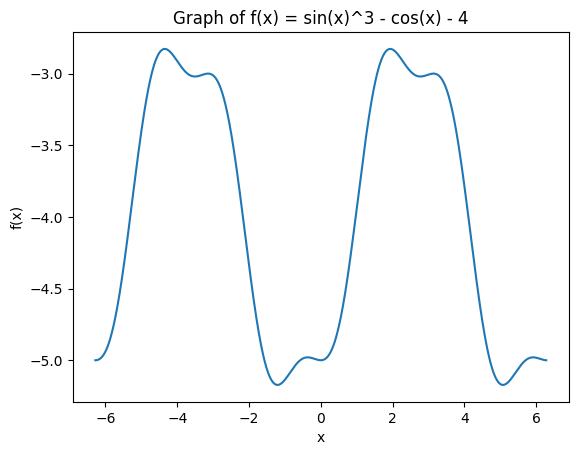

In [8]:
exec(response.replace("`", "").replace("python", ""))

In [2]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

prompt_1 = PromptTemplate(
    template="""
Given the mathematical query, write the approach to solve the query, and some broad steps for 
the solution. Describe the approach briefly and add some guidelines for solution if required. 
The solution could also include non-real or complex equations or solutions.
Do not include the solution itself, but the steps for solution. First consider whether solution 
could be real or complex, then solve for the answer.

Query: {query}
""", 
input_variables=['query']
)
chain_1 = LLMChain(llm=llm, prompt=prompt_1, output_key="guideline")

/home/vscode/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [3]:
prompt_2 = PromptTemplate(
    template="""
Based on the given guidelines, solve the each step of mathematical expression or function 
with detailed explaination of the solution. Explain the solution also in context of the given 
mathematical query. Perform each equation calculation carefully. The solution could also be non-real.
Solve for the complex solution if required.

Query: {query}

Steps: {guideline}
""",
input_variables=['query', 'guideline']
)

chain_2 = LLMChain(llm=llm, prompt=prompt_2, output_key="solution")

In [4]:
from langchain.chains import SequentialChain

simple_chain = SequentialChain(
    chains=[chain_1, chain_2], 
    verbose=True, 
    input_variables=['query'],
    output_variables=['solution']
)

In [5]:
response = simple_chain.run("$$\sin^3(x) - \cos(x) = 4$$")

/home/vscode/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new SequentialChain chain...

> Finished chain.


In [6]:
print(response)

**Step 1: Determine the Nature of the Solution**

The equation involves trigonometric functions, which can have both real and complex solutions.

**Step 2: Solve for Real Solutions**

**Simplify using trigonometric identities:**

$$\sin^3(x) - \cos(x) = 4$$

$$\Rightarrow \sin^3(x) = \cos(x) + 4$$

$$\Rightarrow \sin^3(x) - \cos^2(x) = 4 + \cos^2(x)$$

Using the identity $\sin^2(x) + \cos^2(x) = 1$:

$$\Rightarrow \sin^3(x) - 1 = 4 + \cos^2(x)$$

$$\Rightarrow \sin^3(x) + \cos^2(x) = 5$$

$$\Rightarrow 1 = 5$$

This equation has no real solutions.

**Step 3: Solve for Complex Solutions**

**Use Euler's formula:**

$$\sin(x) = \frac{e^{ix} - e^{-ix}}{2i}$$

$$\cos(x) = \frac{e^{ix} + e^{-ix}}{2}$$

Substitute these expressions into the original equation:

$$\left(\frac{e^{ix} - e^{-ix}}{2i}\right)^3 - \frac{e^{ix} + e^{-ix}}{2} = 4$$

Simplify:

$$\frac{(e^{ix} - e^{-ix})^3}{8i^3} - \frac{e^{ix} + e^{-ix}}{2} = 4$$

Multiply both sides by $8i^3$:

$$(e^{3ix} - 3e^{ix} + 3e^{-ix} - e^{-3